# Tutorial04: Convolutional Neural Networks (CNN)
> Created Aug. 2024 for the FSU Course: *Machine Learning in Physics* <br>
> H. B. Prosper<br>


## Introduction
In this tutorial, we use a convolutional neural network (CNN) to classify galaxies according to their morphology. The [AstroNN](https://astronn.readthedocs.io/en/latest/galaxy10.html) Galaxy10 dataset comprises 17,736 RGB (that is, 3-channel) $256\times256$-pixel images grouped into 10 classes. We use a subset of 12,600 images grouped into 7 morphology classes of 1,800 images each, with each image cropped to $96\times96$ pixels.

## Model

Here is a high-level view of the model we shall fit,

\begin{align*}
\boldsymbol{y} & = \texttt{softmax}(\texttt{flatten} (\texttt{g}(\mathbf{b}_3 + \mathbf{w}_3 * \texttt{g}(\mathbf{b}_2 + \mathbf{w}_2 * \text{g}(\mathbf{b}_1 + \mathbf{w}_1 * \texttt{g}(\mathbf{b}_0 + \mathbf{w}_0 * \boldsymbol{x}) \, ) \, ) \, ) \, ) \, ),
\end{align*}

where $\mathbf{b}$ and $\mathbf{w}$ (the biases and weights) are the parameters of the model and $*$ denotes the convolution operator. 

Here is a programming view, 
```python
model = nn.Sequential(

    # LAYER 0	 (-1, 3, 96, 96))	=>	(-1, 4, 48, 48)
    nn.Conv2d(in_channels=3,
              out_channels=4,
              kernel_size=3,
              stride=1,
              padding=1),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    nn.ReLU(),
    
    # LAYER 1	 (-1, 4, 48, 48))	=>	(-1, 6, 24, 24)
    nn.Conv2d(in_channels=4,
              out_channels=6,
              kernel_size=3,
              stride=1,
              padding=1),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    nn.ReLU(),
    
    # LAYER 2	 (-1, 6, 24, 24))	=>	(-1, 9, 12, 12)
    nn.Conv2d(in_channels=6,
              out_channels=9,
              kernel_size=3,
              stride=1,
              padding=1),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    nn.ReLU(),
    
    # LAYER 3	 (-1, 9, 12, 12))	=>	(-1, 13, 6, 6)
    nn.Conv2d(in_channels=9,
              out_channels=13,
              kernel_size=3,
              stride=1,
              padding=1),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    nn.ReLU(),
    
    # LAYER 4
    nn.Flatten(),
    nn.Linear(468, 7),
    nn.Softmax(dim=1)
        )
```

The functions **softmax**, **flatten**, and **g** are defined as follows:

  * __softmax__ For $K = 7$ output classes, 
\begin{align*}
\text{softmax}(x)_k & = \frac{\exp(x_{k})}{\sum_{j=1}^{K} \exp(x_{j})} ,
\end{align*}
where $x_{k}$ denotes the $k^\text{th}$ output of the previous layer. The
softmax function
bounds the output values to the unit interval and ensure that 
their sum is unity. 

  * __flatten__ Given tensor $\boldsymbol{x}$, this function restructures the tensor into a 1D tensor (that is, a 1D array).

  * __g__ Given tensor $\boldsymbol{x}$, this function operates element-wise on its inputs and returns 
  \begin{align}
  \text{g}(\boldsymbol{x}) = \text{relu}(\text{maxpool}(\boldsymbol{x})),
  \end{align}
  where relu, and maxpool are defined below.

  * __relu__ Given tensor $\boldsymbol{x}$, the function 
\begin{align*}
{\rm relu}(x) &= \begin{cases}
    x, & \text{if } x \gt 0\\
    0              & \text{otherwise}
\end{cases}
\end{align*}
is applied
*element-wise*, that is, to every element of the tensor.

  * __maxpool__ Given tensor $\boldsymbol{x}$, this function uses a moveable window to apply a coarse-graining operation over $\boldsymbol{x}$. In this tutorial, the moveable window  splits the tensor into non-overlapping pieces. For each piece, the maximum pixel value within that piece is returned. For example, if $\boldsymbol{x}$ is a 2D tensor, e.g., a matrix, of shape (96, 96), and the window is of shape (2, 2), maxpool splits the original matrix into $48 \times 48$ non-overlapping pieces of shape (2, 2) and returns the maximum value within each piece, thereby creating a new image of shape (48, 48).

A high-level view is a good way to represent the structure of a model.  But it is also good to try to understand the details...at least once. As is often true, a detailed mathematical description of a complicated function is made easier using an example. 

### Convolutional layer
The input data into the first layer of our model are a batch of $N$ galaxy images $\boldsymbol{x}$ that form a tensor of shape $(N, C=3, H=96, W=96)$, where $C$ denotes the number of input channels and $H$ and $W$ are the height and width of a channel in pixels. The output of the convolutional layer comprises $N$ images, each of $C_\text{out}$ channels. We have chosen to keep the height and width of the images unchanged. Each channel of an input image is cross correlated with each of $C_\text{out} \times C$  parameterized **filter**s of shape $(F, F) = (3, 3)$, indexed by $(j, k)$ where $0 \lt j \lt C_\text{out}-1$ and $0 \lt k \lt C-1$.  We refer to the collection of $C_\text{out} \times C$ filters, which form a 4-component tensor,  as a **kernel**. The first index of the kernel is the number of **output channels**, $C_\text{out} = 4$, the second is the number of **input channels**, $C = 3$, and the remaining two indices are the height and width of the filters. In addition to the $C_\text{out} \times C \times F$ parameters of the kernel there are $C_\text{out}$ bias parameters, one for each output plane.

Unfortunately, the jargon is not consistent across the machine learning literature. What we call a filter is indeed often referred to as a filter, but it is also called a kernel, and what we call a kernel, that is, a stack of one or more filters, often has no specific name attached to it! 

We follow the PyTorch [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) (with $C_\text{in} \equiv C)$ and write the output of a convolutional layer as
\begin{align}
    \text{out}(N_i, C_{\text{out}j}) & = \text{bias}(C_{\text{out}j}) + \sum_{k=0}^{C_\text{in}-1} \text{weight}(C_{\text{out}j}, k) * \text{input}(N_i, k),
\end{align}
where $*$ is the convolutional operator and where for input image $N_i$ the object $\text{input}(N_i, k)$ is its $k^\text{th}$ channel. It may help to describe what's happening in words.

  1. For a given image $N_i$, of which there are $N$ in the batch of images, convolve each input channel $k$ with the filter $\text{weight}(C_{\text{out}j}, k)$ indexed by output channel $C_{\text{out}j}$ and input channel $k$.
  2. Do a pixel-by-pixel sum over the $K$ convolved input channels to create output channel $C_{\text{out}j}$.
  3. Add a constant bias $\text{bias}(C_{\text{out}j})$ to every output pixel computed in step 2.
  4. Repeat 1, 2, and 3 for each of the $C_\text{out}$ output channels, thereby creating an output image with $C_\text{out}$ channels.
     
As noted, the bias and weights are the parameters of the kernel. Given filter $w$ of shape $(3, 3)$ and input channel $x$, the output pixel $y_{i,j}$ with indices $(i, j)$ is computed  as follows
\begin{align}
    y_{i,j} &= \sum_{r=-1}^1 \sum_{s=-1}^1  w_{r,s} \, x_{i+r,\,j+s} ,
\end{align}
where we have chosen to label the central matrix element of the filter with the indices $(0, 0)$ and the other elements with indices that can be positive or negative integers.

However, for the above computations to work as shown, we need to surround each image with strips of pixels. This operation is called **padding**. Since our filter shape is $(3, 3)$, we need to pad every image with a single strip of pixels with value zero. This padding makes it possible to center each of the $12 = 4 \times 3$ filters of shape $(3, 3)$ on every pixel, $(i, j)$, of the input channel. We are free to make other choices.
Since the input image is a $(96, 96)$ matrix padded with 1 strip of pixels around the boundary, and each of the filters is a $(3, 3)$ matrix,
the output of the convolution step will be a tensor of shape $(N, 4, 96, 96)$ provided that we use a **stride** of 1, that is, during the cross correlation we shift the filters a horizontal or vertical step of 1 pixel. Other choices are possible. By
construction, the output of the first convolutional layer will be $N$, 4-channel images of the same size as the original, namely $(96, 96)$.

### Coarse-graining layer
A convolutional layer is often followed by a coarse graining, that is, **down-sampling**, layer that reduces the number of pixels per image. In this tutorial, the number of pixels in the image created by the convolutional layer is reduced by a factor 2 in both directions; that is, each of the 4 channels of the $(96, 96)$-pixel image is down sampled to a $(48, 48)$-pixel channel by replacing the corresponding group of pixels of shape $(2, 2)$ with a pixel whose value is set to the largest value among the group of 4 pixels and using a stride of 2 horizontally and vertically so that the $2\times 2$ windows are nonoverlapping. This operation is called **max pooling**. 
Again, other choices are possible.

After max pooling or some other down-sampling operation, the output tensor has shape $(N, 4, 48, 48)$. A relu **activation function** is applied to each element of this tensor and completes one sequence of operations: cross correlation, down sampling, and nonlinear activation. 
This sequence is repeated until we reach the final layer. The input to the final layer is $N$ $6\times6$-pixel, 13-channel, images. Each image is flattened to a 1D tensor  of size $13 \times 6 \times 6 = 468$, which is the input to a linear layer with 7 outputs. Finally, a softmax function is applied to normalize the sum of the outputs to one.


### Number of parameters
Our model consists of a sequence of 4 triplets ($\texttt{Conv2d}$, $\texttt{MaxPool2d}$, $\texttt{ReLU}$) of operations. The 4 $\texttt{Conv2d}$ operations have kernels with input and output channel counts $(3,4), (4,6), (6, 9)$, and $(9, 13)$, respectively. The same stride and padding is used for every $\texttt{Conv2d}$ operation and the same pooling operation, as described above, is used for every layer. Let $C_\text{in}$ be the number of input channels and $C_\text{out}$ be the number of output channels, and let $(H_F, W_F)$ be the shape of a filter. The number of parameters per $\texttt{Conv2d}$ operation is given $C_\text{in} C_\text{out} H_F W_F + C_\text{out}$ since, by default, there is one bias parameter per output channel. 
The number of parameters in a linear layer with $N_\text{in}$ inputs and $N_{out}$ outputs plus a bias parameter for each output is given by $N_\text{in} N_\text{out} + N_\text{out}$. This yields the following parameter counts for the model.

| Layer | $C_\text{in}$ | $C_\text{out}$ | Count |
| -----: | ----: | ------------: |-------:|        
| 0 | 3 | 4 | 112 |
| 1 | 4 | 6 | 222 |
| 2 | 6 | 9 | 495 |
| 3 | 9 | 13 | 1066 |
| **Layer** | $N_\text{in}$ | $N_\text{out}$ |  |
| 4     | 468  |7  |3283 |
| **Total**  |  |   |5128 |

### Discussion
The net effect of the sequence of nested layers, prior to flattening, is to transform each 3-channel, $(96, 96)$ input image into a 13-channel (6, 6) output image. The hope is that the output image captures the most relevant features of the input image thereby improving the accuracy of the subsequent classification. But why use cross correlation?

The intuition behind the cross correlation operation is that natural images tend to have similar features in different parts of the image. A filter that is sensitive to vertical features would tend to produce an output image that enhances vertical features, while suppressing the expression of horizontal features. It therefore seems plausible that if one could design filters that are sensitive to different image features, the set of filters could potentially transform an image into another in which the most relevant features are enhanced while the least relevant are suppressed. 

In the early days of image recognition systems, researchers tried to describe in software what they considered to be the most relevant features in images. This proved to be extremely difficult and success was limited. Today hand coding is no longer necessary because the values of the parameters of the kernels can be determined automatically by minimizing an appropriate (average) loss function. However, the mere fact that a large number of images is needed to fit these parameters is evidence that current machine learning methods and models, while spectacularly successful, are still far removed from the internal models humans use to learn about the world. 

A young child need be shown labeled objects, cat, dog, doll, truck, car, just a few times before being able to classify them correctly. The child can do this even when the objects are presented to her in orientations that differ from the ones used during the "training phase". This extraordinary ability suggests that the child's brain constructs a fault-tolerant model of each object using only its most relevant features and is able to match rapidly the input image with the stored, or more likely auto-reconstructed, fault-tolerant model. The model is clearly fault tolerant because the child is able to ignore "faults" such as viewing the objects in lighting that differs from that used during the "training phase", or ignoring the fact that now the car has lost a couple of wheels or the doll is now wearing different clothes. 

In spite of the truly impressive recent successes, it is clear that machine learning-based artificial intelligence still has a long way to go. Of course, it could be that the age-old goal of building machines that think like humans is simply the wrong goal. After all, there are already many instances in which researchers have inadvertently succeeded in producing machines that mimic our prejudices, which is hardly progress. Therefore, perhaps we should embrace the "artificial" in artificial intelligence and the possibility that these machines will inevitably "think" differently from us. The trick, of course, is to have them "think" in a way that improves the human condition. 

In [2]:
# standard system modules
import os, sys

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# module to access data in Hierarchical Data Format (HDF or H5 format)
import h5py

# to plot pixelized images
import imageio.v3 as im

# to reimport Python modules
import importlib

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

# update fonts
FONTSIZE = 12
plt.rcParams.update({
    "text.usetex": True, # turn off if the system can'r find late
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": FONTSIZE
})

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

## A Simple Convolution Exercise
Let $y = f * g$ be the convolution of the functions $f(x)$ and $g(x)$. By definition,

$y(t)  = \int f(\tau) \, g(t-\tau) \, d\tau .$

In the exercise below, we compute the convolution of a 1-channel image using $\texttt{Conv2d}$ and using an explicit calculation.

### Define a 1-channel $3 \times 3$-pixel input image

In [2]:
image = np.array([[1,0,2], 
                  [1,1,1],
                  [0,2,0]])
print('image')
print(image)

# pad image with a single row of pixels
I = np.vstack([np.zeros(3), image, np.zeros(3)])
I = np.vstack([np.zeros(5), I.T, np.zeros(5)]).T
print('\npadded image')
print(I)

image.shape, I.shape

image
[[1 0 2]
 [1 1 1]
 [0 2 0]]

padded image
[[0. 0. 0. 0. 0.]
 [0. 1. 0. 2. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0.]]


((3, 3), (5, 5))

### Compute convolution using `Conv2d`

In [3]:
conv2d = nn.Conv2d(in_channels=1, 
                   out_channels=1,
                   kernel_size=3, 
                   stride=1, 
                   padding=1)

# get weights
W = conv2d.state_dict()['weight'].squeeze(0).squeeze(0).numpy()

# get biases
B = conv2d.state_dict()['bias'].numpy()

# convert to a tensor of shape  (N, C, H, W)
X = torch.tensor(image).float().view(1, 1, 3, 3) 

# compute convolution, detach from computational tree, 
# and squeeze out first two dimensions
O = conv2d(X).detach().squeeze(0).squeeze(0).numpy()

O.shape

(3, 3)

### Compute convolution explicitly

In [4]:
n = O.shape[0]  # n x n image
b = B[0]        # bias (one number per output channel)

# create bias matrix
Y = np.array([[b]*n]*n)
print('bias')
print(Y)
print()

# loop over pixels of image (but using padded image)
for i in [1,2,3]:
    for j in [1,2,3]:

        # perform convolution
        for r in [-1,0,1]:
            for s in [-1,0,1]:
                Y[i-1,j-1] += W[r+1, s+1] * I[i+r, j+s]

print('Conv2d')
print(O)
print()

print('By hand')
print(Y)

bias
[[0.20998928 0.20998928 0.20998928]
 [0.20998928 0.20998928 0.20998928]
 [0.20998928 0.20998928 0.20998928]]

Conv2d
[[-0.26929107 -1.0009613  -0.24116203]
 [-0.6319741  -0.55969024 -0.1474343 ]
 [-0.12005869  0.01432195 -0.22602081]]

By hand
[[-0.26929107 -1.0009613  -0.24116205]
 [-0.6319741  -0.5596902  -0.14743426]
 [-0.12005866  0.01432195 -0.22602081]]


## Constants

In [5]:
MODELFILE = 'CNN.dict' # file containing parameters of trained model

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


## Load Galaxy Images
Load galaxy images and normalize pixels by dividing each by 256.

In [6]:
def load_images(filename='../data/galaxy10.h5'):
    with h5py.File(filename, 'r') as F:
        images = np.array(F['images']) / 256 # normalize pixels
        labels = np.array(F['labels'])       # class labels   
    return images, labels
    
def plot_images(images, targets,
                n_rows=4, 
                n_cols=5):

    f_size = (8, n_rows * 1.7)
    
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=f_size)
    
    # note use of flatten() to convert the matrix 
    # of shape (nrows, ncols) to a 1-d array.
    axs = axs.flatten()
    n = len(axs)

    # use "zip" to create an list of shape (N, 3)
    for image, target, ax in zip(images[:n], targets[:n], axs):
        
        ax.axis('off')
        
        ax.imshow(image)
        
        # Note: (x, y) coordinates are in pixels, 
        # where (0, 0) is the upper left corner
        ax.text(8, 16, f'{target:d}', color='white')
        
    plt.savefig('galaxy_images.png')
    
    plt.show()

number of images: 12600


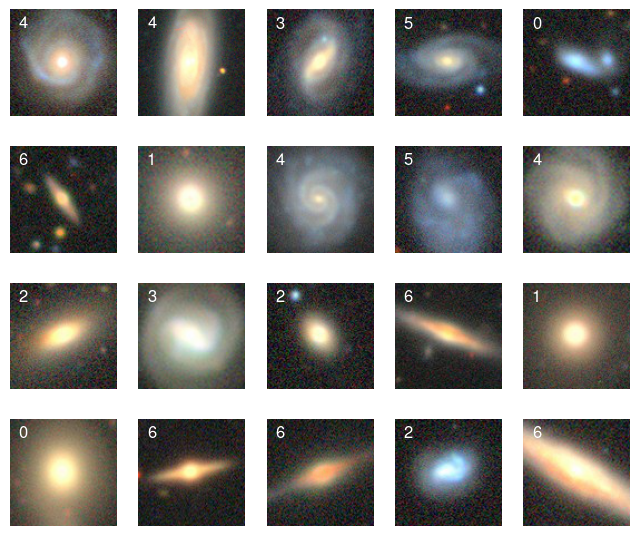

In [7]:
images, targets = load_images()

print(f'number of images: {len(images):d}')

plot_images(images, targets)

## Prepare training and validation datasets
  1. Split data into training, testing, and validation sets.
  2. Change shape of tensors to from $(N, H, W, C)$ to $(N, C, H, W)$.
  3. Move them to computational device.

In [8]:
n_train = 10000
n_test  =  1600
n_valid =  len(images) - n_train - n_test

print("number of images for training:   %10d" % n_train)
print("number of images for testing:    %10d" % n_test)
print("number of images for validation: %10d" % n_valid)

# split and convert to tensors

train_x, X = torch.Tensor(images[:n_train]),  images[n_train:]
train_y, Y = torch.tensor(targets[:n_train], dtype=int), targets[n_train:]

test_x, valid_x = torch.Tensor(X[:n_test]), torch.Tensor(X[n_test:])
test_y, valid_y = torch.tensor(Y[:n_test], dtype=int), torch.tensor(Y[n_test:], dtype=int)

# change shape ( (N, H, W, C) => (N, C, H, W) ) and send to computational device

train_x = train_x.transpose(2,3).transpose(1,2).to(DEVICE)
test_x  = test_x.transpose(2,3).transpose(1,2).to(DEVICE)
valid_x = valid_x.transpose(2,3).transpose(1,2).to(DEVICE)

print()
print(train_x.shape)
print(train_y.shape)
print()

print("number of images for training:   %10d, %10d" % (len(train_x), len(train_y)))
print("number of images for testing:    %10d, %10d" % (len(test_x),  len(test_y)))
print("number of images for validation: %10d, %10d" % (len(valid_x), len(valid_y)))

number of images for training:        10000
number of images for testing:          1600
number of images for validation:       1000

torch.Size([10000, 3, 96, 96])
torch.Size([10000])

number of images for training:        10000,      10000
number of images for testing:          1600,       1600
number of images for validation:       1000,       1000


### Building a model as a Python class

The **nn.Sequential** class is the simplest way to construct (simple) PyTorch models. But if you want more control over the model, you can achieve this by building the model as a class inheriting from **nn.Module** as in the following cell. 

We use some notebook magic to write the following cell to a file, which can then be imported into another notebook. Note: we need to import the saved class to make it visible to this notebook!

In [9]:
def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
%%writefile CNN.py
import torch.nn as nn

G = 1.5                 # growth of filter count

L = 4                   # number of convolutional layers

C, H, W = 3, 96, 96     # input channels, height, weight

I, S, P, M = 3, 1, 1, 2 # kernel size, stride, padding, pooling kernel size

cmd = ''
for layer in range(L):
 
    C0 = C
    H0 = H
    W0 = W
    
    C *= G
    C = int(C)
    H = int(H/M)
    W = int(W/M)

    cmd += f'''
    # LAYER {layer:d}\t (-1, {C0:d}, {H0:d}, {W0:d}))\t=>\t(-1, {C:d}, {H:d}, {W:d})
    nn.Conv2d(in_channels={C0:d},
              out_channels={C:d},
              kernel_size={I:d},
              stride={S:d},
              padding={P:}),
    nn.MaxPool2d(kernel_size=({M:d}, {M:d}), stride={M:d}),
    nn.ReLU(),
    '''
    
J = int(C*H*W)   # number of inputs to Linear function
K = 7            # number of classes

layer += 1

cmd = f'''
model = nn.Sequential(
{cmd:s}
    # LAYER {layer:d}
    nn.Flatten(),
    nn.Linear({J:d}, {K:d}),
    nn.Softmax(dim=1)
        )
'''
exec(cmd)

Overwriting CNN.py


In [63]:
import CNN
importlib.reload(CNN)

model = CNN.model.to(DEVICE)

print('number of parameters:', number_of_parameters(model))

print(CNN.cmd)

print(model)

number of parameters: 5178

model = nn.Sequential(

    # LAYER 0	 (-1, 3, 96, 96))	=>	(-1, 4, 48, 48)
    nn.Conv2d(in_channels=3,
              out_channels=4,
              kernel_size=3,
              stride=1,
              padding=1),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    nn.ReLU(),
    
    # LAYER 1	 (-1, 4, 48, 48))	=>	(-1, 6, 24, 24)
    nn.Conv2d(in_channels=4,
              out_channels=6,
              kernel_size=3,
              stride=1,
              padding=1),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    nn.ReLU(),
    
    # LAYER 2	 (-1, 6, 24, 24))	=>	(-1, 9, 12, 12)
    nn.Conv2d(in_channels=6,
              out_channels=9,
              kernel_size=3,
              stride=1,
              padding=1),
    nn.MaxPool2d(kernel_size=(2, 2), stride=2),
    nn.ReLU(),
    
    # LAYER 3	 (-1, 9, 12, 12))	=>	(-1, 13, 6, 6)
    nn.Conv2d(in_channels=9,
              out_channels=13,
              kernel_size=3,
              stride=1,
              

### Count parameters explicitly

In [64]:
# get parameter names (#.weight, #.bias)

keys = list(model.state_dict().keys()) 

n_params = 0

# loop over parameters in steps of 2

for i in range(0,len(keys),2):
    
    W = model.state_dict()[keys[i]]     # weights
    B = model.state_dict()[keys[i+1]]   # biases

    # calculate number of parameters / Conv2d
    try:
        C_out, C_in, H_F, W_F = W.shape
        n = C_in*C_out*H_F*W_F + C_out
    except:
        C_out, C_in = W.shape
        n = C_in * C_out + C_out

    n_params += n
    
    print(f'{C_in:5d}, {C_out:5d}, {n:5d}')
    
print()
print('number of parameters:', number_of_parameters(model), n_params)

    3,     4,   112
    4,     6,   222
    6,     9,   495
    9,    13,  1066
  468,     7,  3283

number of parameters: 5178 5178


## Define empirical risk (aka average loss)

In [65]:
class AverageLoss():
    def __init__(self):
        pass
    
    def __call__(self, outputs, targets):
        """
        outputs:  shape (batch_size, number_classes), pre-softmax outputs
        targets:  shape (batch_size, ), class indices [0,...,C-1] 
        """        
        # ---------------------------------------------------------------       
        # The cross entropy is defined by
        #   H(p, f) = -sum_i p_i log(f_i)
        #
        # The entropy is defined by
        #   H(p)    = -sum_i p_i log(p_i)
        #
        # and the Kullback-Leibler divergence by
        #   D(p,f)  = sum_i p_i log(p_i/f_i)
        #           = -sum_i p_i log(f_i) - [-sum_i p_i log(p_i)]
        #           = H(p, f) - H(p)
        #
        # The cross entropy is minimized when the estimated 
        # probabilities f_i match the true probabilities p_i, in which 
        # case the cross entropy equals the entropy.
        # --------------------------------------------------------------- 
        # Note the numpy-like syntax for accessing elements of the
        # tensor: outputs[list1, list2] 
        
        # outputs is a (-1, 7) tensor. For each image pick the output 
        # value corresponding to its class. Recall that targets is 
        # a 1D tensor (basically, a 1D array) of class labels. 
        # For every row, pick the value in the column corresponding
        # to the class label.
        
        outputs  = outputs[range(len(targets)), targets]
        
        return -torch.mean(torch.log(outputs))

In [66]:
def get_random_batch(x, y, batch_size):
    indices = torch.randint(0, len(x)-1, size=(batch_size,))
    return x[indices], y[indices]

def accuracy(outputs, targets):
    # For each image, return its predicted class label using argmax.
    #
    # argmax scans the numpy along the specified axis, here the 
    # horizontal axis, which is in the class direction, and returns the
    # ordinal value of the maximum value, which is the predicted class. 
    # Note: outputs must be converted from a tensor to a numpy array 
    # before being passed to argmax. axis=1 is to numpy what dim=1 is
    # to PyTorch.
    outputs = np.argmax(outputs.data.cpu().numpy(), axis=1)
    
    # count how often the predicted class matches the actual class and
    # compute the fraction of correct predictions. 
    # Note: targets must be converted to a numpy array for the 
    # comparison to work since outputs is a numpy array.
    return float(np.mean(outputs==targets.data.cpu().numpy()))

In [67]:
def train(model, optimizer, getbatch, loss_fn, train_x, train_y, batch_size):
    
    model.train() # training mode
    
    # get a batch of training data
    x, y = getbatch(train_x, train_y, batch_size)
    
    # compute output of model
    out = model(x)
    
    # compute loss functions, given the model outputs and the targets
    loss = loss_fn(out, y)
    
    optimizer.zero_grad()  # clear previous gradients
    
    loss.backward()        # compute gradients
    
    optimizer.step()       # move one step
        
def validate(model, train_x, train_y, valid_x, valid_y):
    
    n_valid = len(valid_x)
    
    model.eval() # evaluation mode
    
    with torch.no_grad():  # no need to compute gradients wrt. to x, t
        
        out   = model(train_x[:n_valid])
        acc_t = accuracy(out, train_y[:n_valid])
  
        out   = model(valid_x)
        acc_v = accuracy(out, valid_y)

    return acc_t, acc_v
               
def trainModel(model, optimizer, getbatch, averageloss, modelfile,
               train_x, train_t,
               valid_x, valid_t,
               n_iterations, batch_size, 
               xx=[], yy_t=[], yy_v=[], step=100):

    max_acc_v = -1e30
    print('%10s\t%10s\t%10s' % ('iteration', 'training', 'validation'))
    
    for ii in range(n_iterations):
        
        train(model, optimizer, getbatch, averageloss, 
              train_x, train_t, 
              batch_size)

        if ii  < 5:
            
            acc_t, acc_v = validate(model, 
                                    train_x, train_t, 
                                    valid_x, valid_t)
            
            print("%10d\t%10.4f\t%10.4f" % (ii, acc_t, acc_v))
            
            if len(xx) == 0:
                xx.append(0)
            else:
                xx.append(xx[-1]+step)
                
            yy_t.append(acc_t)
            yy_v.append(acc_v)

        elif ii % step == 0:
            
            acc_t, acc_v = validate(model, 
                                    train_x, train_t, 
                                    valid_x, valid_t)
            
            print("\r%10d\t%10.4f\t%10.4f" % (ii, acc_t, acc_v), end='')

            xx.append(xx[-1]+step)
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
        if acc_v > max_acc_v:
            max_acc_v = acc_v
            torch.save(model.state_dict(), modelfile)
            
    print()
    return xx, yy_t, yy_v

## Train

In [68]:
def plot(xx, yy_t, yy_v):
    # create an empty figure
    fig = plt.figure(figsize=(6, 4))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    
    # axis limits
    ax.set_ylim((0.0, 1.0))
    ax.set_xlim((xx[0], xx[-1]))
    
    ax.plot(xx, yy_t, 'b', label='Training')
    ax.plot(xx, yy_v, 'r', label='Validation')
    
    ax.set_title('Training and Validation Accuracy', fontsize=16)
    ax.set_xlabel('Iterations', fontsize=16)
    ax.set_ylabel('Accuracy', fontsize=16)
    ax.grid(True, which="both", linestyle='-')
    
    ax.legend(loc='lower right')
    fig.tight_layout()
    plt.savefig('accuracy.png')
    plt.show()

In [69]:
xx   = []  # iteration numbers
yy_t = []  # prediction accuracy using training data
yy_v = []  # prediction accuracy using validation data

 iteration	  training	validation
         0	    0.1470	    0.1310
         1	    0.1470	    0.1310
         2	    0.1380	    0.1510
         3	    0.1380	    0.1510
         4	    0.1380	    0.1510
      9900	    0.8130	    0.7080

done!


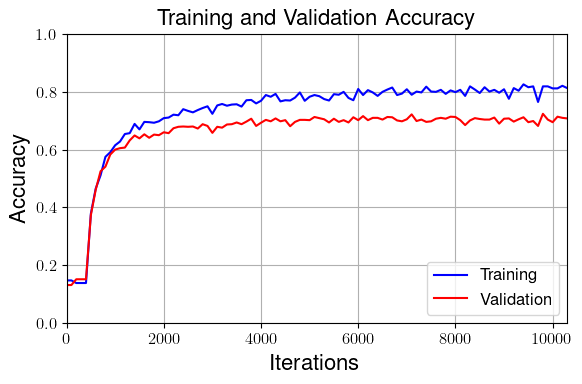

In [70]:
n_iter  = 10000    # number of iterations
n_batch =   200    # number of images/training batch
step    =   100
learning_rate = 1.0e-3

avloss  = AverageLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

xx, yy_t, yy_v = trainModel(model, optimizer, get_random_batch, avloss, MODELFILE,
                            train_x, train_y, 
                            valid_x, valid_y,
                            n_iter,  n_batch, 
                            xx, yy_t, yy_v, 
                            step=step)

print("\ndone!")

plot(xx, yy_t, yy_v)

## Compute accuracy on test set

In [71]:
model.load_state_dict(torch.load(MODELFILE))

model.eval()

y_pred = model(test_x)

acc = accuracy(y_pred, test_y)

print('Percentage of correct predictions: %8.1f%s' % (100*acc, '%'))

Percentage of correct predictions:     71.4%


In [72]:
def plot_confusion_matrix(y_pred, y, t=0.5, gfile='confusion_matrix.png'):
    
    from sklearn.metrics import confusion_matrix
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true=y, y_pred=y_pred)

    # Print the confusion matrix using Matplotlib
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.rainbow, alpha=0.8)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], 
                    va='center', ha='center', size='x-large')
 
    plt.xlabel('Predicted Labels', fontsize=16)
    plt.ylabel('True Labels', fontsize=16)
    plt.title(f'Confusion Matrix', fontsize=16)
    fig.tight_layout()
    plt.savefig(gfile)
    plt.show()

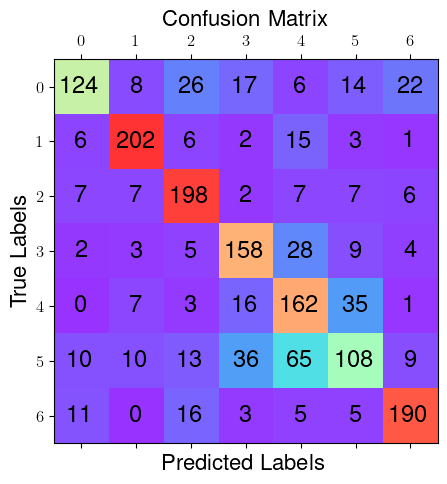

In [73]:
y_hat  = np.argmax(y_pred.data.cpu().numpy(), axis=1)

y_true = test_y.data.cpu().numpy()
 
plot_confusion_matrix(y_hat, y_true)